In [1]:
import os
import pickle
import torch


In [2]:
from datasets import Dataset 
from ragas import evaluate
from ragas.metrics import answer_relevancy
from ragas.llms import LangchainLLMWrapper


c:\Users\RDebe\anaconda3\envs\Evaluation_RAGAS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_core.pydantic_v1 import BaseModel, Field, validator

### Load Pickle files and Preprocess

#### Define classes for loading pickle file
In case feedback is provided specific Feedback Score class is in value of feedback key under generate_final_answer nodes

In [4]:
class FeedbackScore(BaseModel):
    """Evaluates the quality of an answer with a score from 0 to 100."""

    feedback_score: int = Field(
        default=0,
        ge=0,
        le=100,
        description="Score tussen 0 en 100 bepalend voor de kwaliteit en relevantie van het antwoord gebaseerd op de documenten."
    )

    @validator('feedback_score')
    def check_score_range(cls, value):
        """Ensure the score is within the allowed range."""
        if not (0 <= value <= 100):
            raise ValueError('Score moet tussen 0 en 100 zijn')
        return value

#### Load Data

In [11]:
def load_pkl(folder_path):
    combined_dict = {}

    # Iterate through all files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as f:
                
                data = pickle.load(f)
                
                for ecli, nodes in data.items():
    # Remove 'generate_basic_2' -> not needed for evaluation
                    nodes.pop('generate_basic_2', None)
                    
    # Filter out 'generate' nodes with empty 'documents' key -> no use in evaluation
                    nodes_to_remove = []
                    for node_key, node_value in nodes.items():
                        if 'generate' in node_key and node_value.get('documents') in (None, [], {}):
                            nodes_to_remove.append(node_key)
                    
                    for node_key in nodes_to_remove:
                        nodes.pop(node_key, None)
                    
    # Merge the data into the combined dictionary
                    if ecli in combined_dict:
                        combined_dict[ecli].update(nodes)
                    else:
                        combined_dict[ecli] = nodes

    return combined_dict

In [12]:
combined_results = load_pkl('LLAMA')

In [13]:
len(combined_results)

1020

In [14]:
# check structure of the combined results 
# and check correct removal of nodes not needed for evaluation
for ecli, nodes in list(combined_results.items()):
    for node_key, node_value in nodes.items():
            # should result in no print statements
            if 'generate' in node_key and node_value.get('documents') is None:
                print(f"  Node: {node_key}, Documents: {node_value.get('documents')}")
            # if 'generate' in node_key and node_value.get('documents') is not None:
            #      print(f"  Node: {node_key}, Documents: {len(node_value.get('documents'))}")
            

In [15]:
combined_results['ECLI_NL_RBZWB_2021_1987'].keys()

dict_keys(['generate_basic_1', 'grade_documents_1', 'generate_1', 'generate_final_answer_1'])

#### Subset for feedback improvement

In [72]:
def filter_combined_results(combined_dict):
    filtered_dict = {k: v for k, v in combined_dict.items() 
                     if 'generate_final_answer_1' in v and 'generate_final_answer_2' in v}
    return filtered_dict

In [73]:
fb_subset = filter_combined_results(combined_results)

In [75]:
fb_subset.keys()

dict_keys(['ECLI_NL_RBMNE_2022_4294', 'ECLI_NL_RBAMS_2024_1429', 'ECLI_NL_RBAMS_2021_7553', 'ECLI_NL_RBOVE_2023_1928', 'ECLI_NL_RBNHO_2023_594', 'ECLI_NL_RBMNE_2019_1592', 'ECLI_NL_RBAMS_2022_7863', 'ECLI_NL_HR_2022_838'])

#### Construct evaluation datasets & Metrics

* Create data set per generation node 
* Calculate hit rate on grade_document nodes
* Calculate judge relevacny on presence of feedback in final_answer nodes. If no feedback is present --> LLM has judged answer to be relevant (1)
* Calculate improvement between final_1 relevancy if feedback was present versus final_2 relevancy 

In [18]:


def get_eval_data(results):
    eval_datasets = {
        'generate_basic_1': {'question': [], 'answer': [], 'contexts': []},
        'generate_1': {'question': [], 'answer': [], 'contexts': []},
        'generate_2': {'question': [], 'answer': [], 'contexts': []},
        'generate_final_answer_1': {'question': [], 'answer': [], 'contexts': []},
        'generate_final_answer_2': {'question': [], 'answer': [], 'contexts': []}
    }
    
    for ecli, outputs in results.items():
        for key, output in outputs.items():
             if key in eval_datasets:
                eval_datasets[key]['question'].append(output['question'])
                eval_datasets[key]['answer'].append(output['generation'])
                eval_datasets[key]['contexts'].append([doc for doc in output['documents']])
    
    return eval_datasets


            

In [19]:
data = get_eval_data(combined_results)

In [87]:
data_subset = get_eval_data(fb_subset)

In [88]:
data['generate_final_answer_2'].keys()

dict_keys(['question', 'answer', 'contexts'])

In [89]:
data_subset['generate_final_answer_2'].keys()

dict_keys(['question', 'answer', 'contexts'])

In [81]:
# check lengths to see distribution over the 'generate' nodes
for key in data.keys():
    print(f"{key}, {len(data[key]['question'])}")


generate_basic_1, 1020
generate_1, 1014
generate_2, 192
generate_final_answer_1, 998
generate_final_answer_2, 8


In [144]:
dataset = Dataset.from_dict(data['generate_basic_1'])
dataset

Dataset({
    features: ['question', 'answer', 'contexts'],
    num_rows: 1020
})

In [82]:
# check lengths to see if subset is correct
for key in data_subset.keys():
    print(f"{key}, {len(data_subset[key]['question'])}")

generate_basic_1, 8
generate_1, 8
generate_2, 2
generate_final_answer_1, 8
generate_final_answer_2, 8


In [91]:
dataset_subset = Dataset.from_dict(data_subset['generate_final_answer_2'])

In [92]:
# check structure
dataset_subset

Dataset({
    features: ['question', 'answer', 'contexts'],
    num_rows: 8
})

In [22]:
metrics = [answer_relevancy]


### GPT 3.5-turbo 0125 Evaluator

In [208]:
os.environ['OPENAI_API_KEY'] = 'yOUR_API_KEY'

In [196]:

from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI

In [209]:
llm_gpt = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0, api_key=os.environ['OPENAI_API_KEY'])
embeddings_gpt = OpenAIEmbeddings(model='text-embedding-3-small')

In [210]:
llm_gpt = LangchainLLMWrapper(llm_gpt)

In [211]:
for m in metrics:
    # change LLM for metric
    m.__setattr__("llm", llm_gpt)

    # check if this metric needs embeddings
    if hasattr(m, "embeddings"):
        # if so change with OpenAI Embeddings
        m.__setattr__("embeddings", embeddings_gpt)

In [ ]:
score_gpt = evaluate(dataset,
                     metrics=metrics,
                     raise_exceptions=False)


In [37]:
score_gpt

{'faithfulness': 0.9631, 'answer_relevancy': 0.7608, 'context_relevancy': 0.1051}

### Gemini 1.5-PRO Evaluator using VertexAI

In [23]:

from langchain.chat_models import ChatVertexAI
from langchain.embeddings import VertexAIEmbeddings

In [24]:
import google.auth

In [25]:
config = {
    "project_id": "YOUR_PROJECT_ID",
}

# authenticate to GCP
creds, _ = google.auth.default(quota_project_id="YOUR_PROJECT_ID")

In [26]:
import vertexai

In [27]:
vertexai.init(project="YOUR_PROJECT_ID")


In [28]:
llm = ChatVertexAI(temperature=0, model='gemini-pro', credentials=creds)
vertexai_embeddings = VertexAIEmbeddings(credentials=creds)

c:\Users\RDebe\anaconda3\envs\Evaluation_RAGAS\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `ChatVertexAI` was deprecated in LangChain 0.0.12 and will be removed in 0.3.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import ChatVertexAI`.
  warn_deprecated(
c:\Users\RDebe\anaconda3\envs\Evaluation_RAGAS\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `VertexAIEmbeddings` was deprecated in LangChain 0.0.12 and will be removed in 0.3.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import VertexAIEmbeddings`.
  warn_deprecated(
Model_name will become a required ar

In [29]:
from ragas.llms import LangchainLLMWrapper
ragas_vertexai_llm = LangchainLLMWrapper(llm)

In [30]:
for m in metrics:
    # change LLM for metric
    m.__setattr__("llm", ragas_vertexai_llm)

    # check if this metric needs embeddings
    if hasattr(m, "embeddings"):
        # if so change with VertexAI Embeddings
        m.__setattr__("embeddings", vertexai_embeddings)

In [31]:
print(metrics)

[AnswerRelevancy(embeddings=VertexAIEmbeddings(project=None, location='us-central1', request_parallelism=5, max_retries=6, stop=None, model_name='textembedding-gecko@001', client=<vertexai.language_models.TextEmbeddingModel object at 0x000002282E3C2030>, client_preview=None, temperature=0.0, max_output_tokens=128, top_p=0.95, top_k=40, credentials=<google.oauth2.credentials.Credentials object at 0x00000228242D6480>, n=1, streaming=False, instance={'max_batch_size': 250, 'batch_size': 250, 'min_batch_size': 5, 'min_good_batch_size': 5, 'lock': <unlocked _thread.lock object at 0x000002282E52B1C0>, 'batch_size_validated': False, 'task_executor': <concurrent.futures.thread.ThreadPoolExecutor object at 0x000002282C28ACF0>, 'embeddings_task_type_supported': False}, show_progress_bar=False), llm=LangchainLLMWrapper(run_config=RunConfig(timeout=60, max_retries=10, max_wait=60, max_workers=16, exception_types=<class 'Exception'>)), name='answer_relevancy', evaluation_mode=<EvaluationMode.qac: 1

In [32]:
from ragas import adapt
# llm is base model, other is in wrapper
adapt(metrics=metrics, language="dutch", llm=llm)

In [100]:
print(metrics)

[AnswerRelevancy(embeddings=VertexAIEmbeddings(project=None, location='us-central1', request_parallelism=5, max_retries=6, stop=None, model_name='textembedding-gecko@001', client=<vertexai.language_models.TextEmbeddingModel object at 0x000002282E3C2030>, client_preview=None, temperature=0.0, max_output_tokens=128, top_p=0.95, top_k=40, credentials=<google.oauth2.credentials.Credentials object at 0x00000228242D6480>, n=1, streaming=False, instance={'max_batch_size': 250, 'batch_size': 250, 'min_batch_size': 5, 'min_good_batch_size': 5, 'lock': <unlocked _thread.lock object at 0x000002282E52B1C0>, 'batch_size_validated': False, 'task_executor': <concurrent.futures.thread.ThreadPoolExecutor object at 0x000002282C28ACF0>, 'embeddings_task_type_supported': False}, show_progress_bar=False), llm=LangchainLLMWrapper(run_config=RunConfig(timeout=60, max_retries=10, max_wait=60, max_workers=16, exception_types=<class 'Exception'>)), name='answer_relevancy', evaluation_mode=<EvaluationMode.qac: 1

In [34]:
evaluation_scores = {}

#### Evaluate Across ALL cases
evaluation for each generation node

In [ ]:

for key in data.keys():
    dataset = Dataset.from_dict(data[key])
    
    score_vertex_NL = evaluate(dataset=dataset,  
                               metrics=metrics,
                               raise_exceptions=False)
    evaluation_scores[key] = score_vertex_NL

In [54]:
evaluation_scores

{'generate_basic_1': {'answer_relevancy': 0.7717},
 'generate_1': {'answer_relevancy': 0.7564},
 'generate_2': {'answer_relevancy': 0.8393},
 'generate_final_answer_1': {'answer_relevancy': 0.8613},
 'generate_final_answer_2': {'answer_relevancy': 0.7570}}

In [ ]:
for key in evaluation_scores.keys():
    evaluation_scores[key].to_pandas().to_excel(f'LLAMA{key}.xlsx')

#### Evaluation of (NO) improvement before and after feedback

In [101]:
eval_feedback = {}

In [109]:

for key in data_subset.keys():
    dataset = Dataset.from_dict(data_subset[key])
    
    score_FB_NL = evaluate(dataset=dataset,  
                               metrics=metrics,
                               raise_exceptions=False)
    eval_feedback[key] = score_FB_NL


Evaluating: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


In [104]:
eval_feedback

{'generate_basic_1': {'answer_relevancy': 0.7178},
 'generate_1': {'answer_relevancy': 0.6951},
 'generate_2': {'answer_relevancy': 0.0000},
 'generate_final_answer_1': {'answer_relevancy': 0.6331},
 'generate_final_answer_2': {'answer_relevancy': 0.7680}}

In [96]:
for key in eval_feedback.keys():
    eval_feedback[key].to_pandas().to_excel(f'LLAMA_Feedback{key}.xlsx')

### HIT RATES

#### Retrieval HITS

In [114]:
def calculate_hit_rates(results):
    hit_rates = []
    hit_rates_0 = []
    hit_rates_1 = []
    hit_rates_2 = []
    hit_rates_3 = []

    for ecli, nodes in results.items():
        for node_key, node_value in nodes.items():
            # get hit rates for first iteration
            if node_key == 'grade_documents_1':
                n_relevant_docs = node_value.get('n_relevant_docs')
                n_ranked_docs = node_value.get('n_ranked_docs')  
                
                hit_rate = n_relevant_docs / n_ranked_docs
                hit_rates.append(hit_rate)
                
                # store hit rates for first iteration
                hit_rates_3.append(hit_rate)
                
                # if at first iteration threshold is met -> append to hit_rates_0
                if n_relevant_docs >= 4:
                    hit_rates_0.append(hit_rate)
                else:
                    hit_rates_1.append(hit_rate)

            # get hit rates for second iteration
            if node_key == 'grade_documents_2':
                n_relevant_docs = node_value.get('n_relevant_docs')
                n_ranked_docs = node_value.get('n_ranked_docs') 
                
                hit_rate_2 = n_relevant_docs / n_ranked_docs
                hit_rates_2.append(hit_rate_2)
                # store hit rates for second iteration

                hit_rates_3.append(hit_rate_2)
    
    return hit_rates, hit_rates_0, hit_rates_1, hit_rates_2, hit_rates_3

def average_hit_rate(hit_rates):
    return sum(hit_rates) / len(hit_rates)

In [115]:
hit_rates, hit_rates_0, hit_rates_1, hit_rates_2, hit_rates_3 = calculate_hit_rates(combined_results)

In [116]:
# average hiut rate for all iterations
average_hit_rate(hit_rates_3)

0.7057379236722712

In [50]:
# average hit ratefor first  iterations
average_hit_rate(hit_rates)

0.7680228758169935

In [51]:
# average hit rate when no second iteration of retrieval was needed
average_hit_rate(hit_rates_0)

0.8863885377159714

In [52]:
# average hit rate over all ECLI and iterations with less than 3 relevant docs
average_hit_rate(hit_rates_1)

0.35917030567685587

In [53]:
# average hit rate over all ECLI after second iteration of retrieval
average_hit_rate(hit_rates_2)

0.4283114992721979

#### Distribution Plots Hit Rate

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
def plot_hit_rate_distributions(hit_rates_dict):
    plt.figure(figsize=(14, 10))
    
    plot_titles = [
        'Distribution of All Hit Rates',
        'Hit Rates (n_relevant_docs >= 4 in First Iteration)',
        'Hit Rates (n_relevant_docs < 4 in First Iteration)',
        'Hit Rates from Second Iteration'
    ]
    
    for idx, (hit_rates, title) in enumerate(zip(hit_rates_dict.values(), plot_titles), start=1):
        plt.subplot(2, 2, idx)
        sns.histplot(hit_rates, bins=7, kde=True, color='skyblue', edgecolor='black')
        plt.title(title, fontsize=14)
        plt.xlabel('Hit Rate', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xlim(0,1)

        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

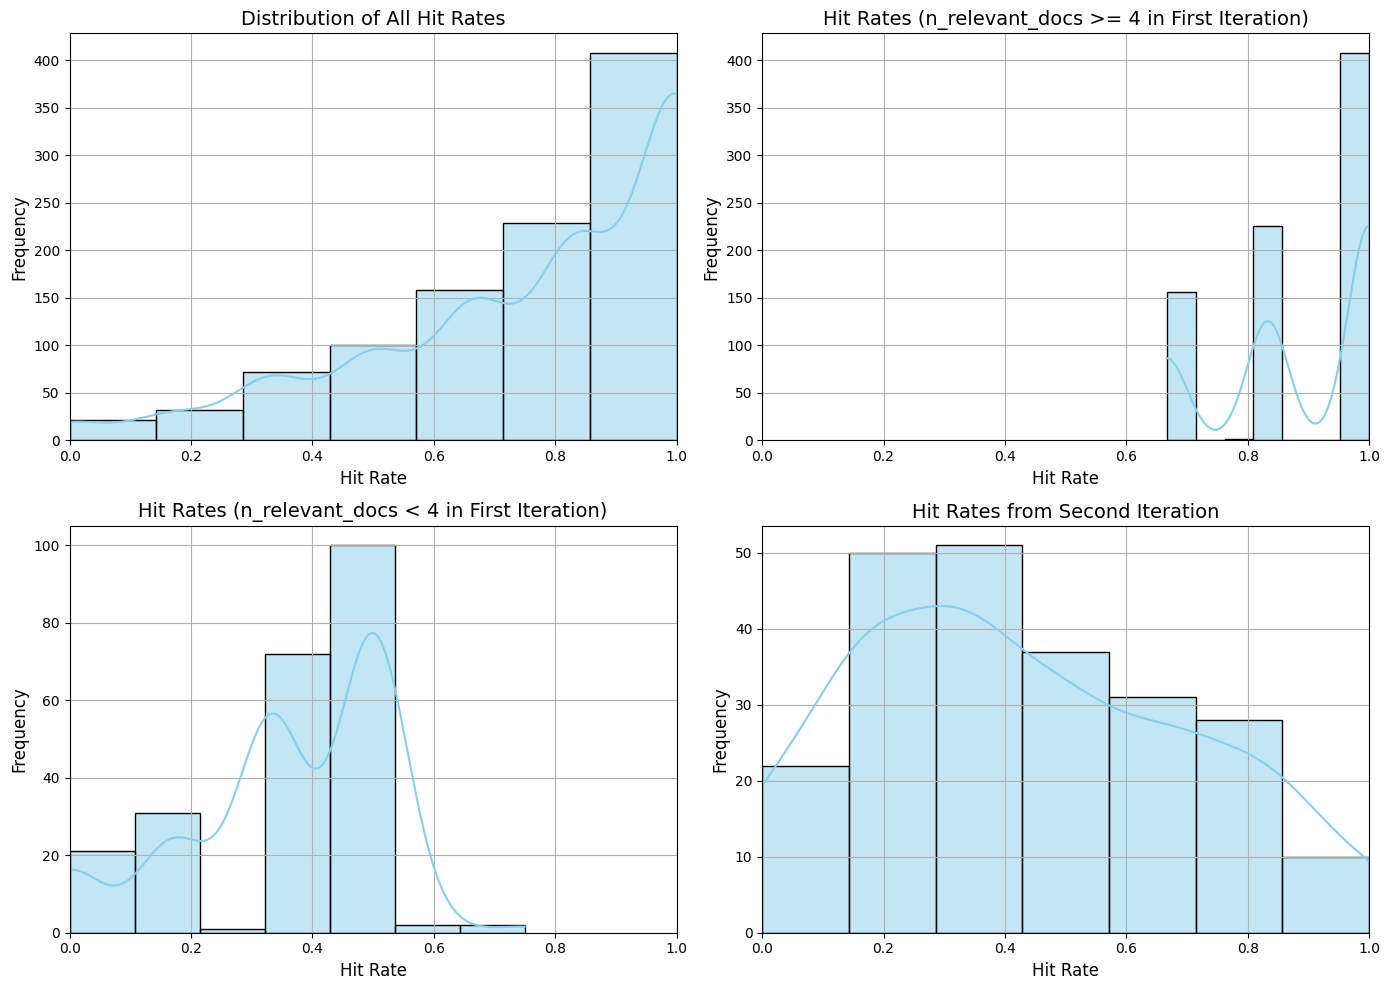

In [129]:
hit_rates_dict = {
    'all': hit_rates,
    'first_iteration_high': hit_rates_0,
    'first_iteration_low': hit_rates_1,
    'second_iteration': hit_rates_2,
}

plot_hit_rate_distributions(hit_rates_dict)

#### Judge HITS

In [58]:
# Overall hit rate deemed relevant by LLM
len(data['generate_final_answer_1']['question']) / len(data['generate_basic_1']['question'])

0.9784313725490196